# Predicting Exchange Rates for US Dollar to Euro

In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pyramid.arima import auto_arima
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

### Exchange Rate Data
Exchange rate for US Dollars to Euros from the initial use of the Euro in January 2002 through August 2018 as found at https://www.federalreserve.gov/data.htm

In [2]:
# exchange rate data
USEU_raw = pd.read_csv('USD_EU.csv', header=5)

USEU_raw.head()

,Time Period,RXI$US_N.B.EU
0,2002-01-01,ND
1,2002-01-02,0.9031
2,2002-01-03,0.8992
3,2002-01-04,0.8946
4,2002-01-07,0.8931


The head of our dataset shows no data ('ND') is availabe for 2002-01-01.  Since the euro was first used on that date, there was no value for it.  Let's look at that first year of data.

In [3]:
USEU_2002 = USEU_raw.copy()

# convert index to datetime
USEU_2002['Date'] = USEU_raw['Time Period']

# drop data from first year of euro use
USEU_2002 = USEU_2002[USEU_2002.Date < '2003-01-01']

# Convert exchange rate to a number, with coersion to throw NAs if conversion not possible
USEU_2002['Rate'] = pd.to_numeric(USEU_2002['RXI$US_N.B.EU'], errors='coerce')

# drop original columns
USEU_2002 = USEU_2002.drop(columns=['Time Period', 'RXI$US_N.B.EU'])

# Remove NAs and NDs
USEU_2002.dropna(inplace=True)

USEU_2002.shape

(251, 2)

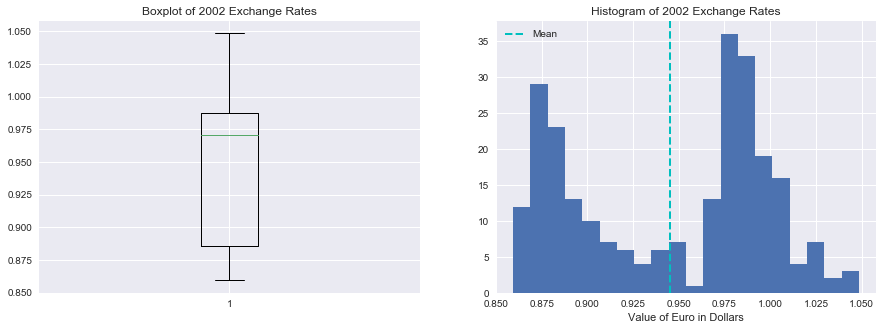

In [4]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(USEU_2002.Rate)
plt.title('Boxplot of 2002 Exchange Rates')

plt.subplot(1, 2, 2)
plt.xlabel('Value of Euro in Dollars')
plt.hist(USEU_2002.Rate, bins=20)
plt.axvline(USEU_2002.Rate.mean(), color='c', linestyle='dashed', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Histogram of 2002 Exchange Rates')
plt.show()

In [5]:
USEU_2002.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,251.0,0.945384,0.053321,0.8594,0.88605,0.9708,0.9875,1.0485


The data from 2002 contains the lowest euro values, with a mean of about 95 cents.  We'll drop the first year of data to get a more established value of the exchange rate.

In [6]:
USEU_data = USEU_raw.copy()

# convert index to datetime
USEU_data['Date'] = pd.to_datetime(USEU_raw['Time Period'])

# drop data from first year of euro use
USEU_data = USEU_data[USEU_data.Date >= '2003-01-01']

# Convert exchange rate to a number, with coersion to throw NAs if conversion not possible
USEU_data['Rate'] = pd.to_numeric(USEU_data['RXI$US_N.B.EU'], errors='coerce')

# drop original columns
USEU_data = USEU_data.drop(columns=['Time Period', 'RXI$US_N.B.EU'])

# Remove NAs and NDs
USEU_data.dropna(inplace=True)

# reset index to sequential from 0
USEU_data.reset_index(drop=True, inplace=True)

USEU_data.shape

(3938, 2)

In [7]:
USEU_data.head()

,Date,Rate
0,2003-01-02,1.0361
1,2003-01-03,1.0418
2,2003-01-06,1.0469
3,2003-01-07,1.0419
4,2003-01-08,1.0447


In [8]:
USEU_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,3938.0,1.271777,0.121051,1.0361,1.178825,1.27795,1.353875,1.601


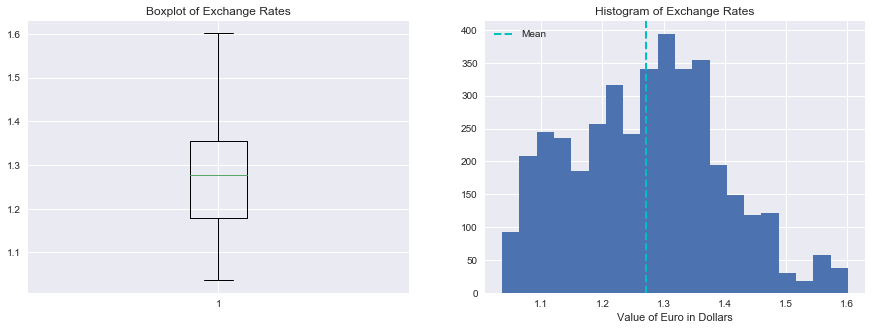

In [9]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(USEU_data.Rate)
plt.title('Boxplot of Exchange Rates')

plt.subplot(1, 2, 2)
plt.xlabel('Value of Euro in Dollars')
plt.hist(USEU_data.Rate, bins=20)
plt.axvline(USEU_data.Rate.mean(), color='c', linestyle='dashed', linewidth=2, label="Mean")
plt.legend(loc='upper left') 
plt.title('Histogram of Exchange Rates')
plt.show()

Looking at the data from 2003 forward, we see a mean of 1.27 with a range from 1.04 to 1.60 - the boxplot shws no outliers.

### Time Series Analysis
The first step in working with our data is to look at the influence of time on the exchange rate.  We will create a time series, with the date as the index.

In [10]:
# set time series
time_series = USEU_data.copy()
time_series.index = pd.to_datetime(time_series['Date'])
time_series = time_series.drop(columns=['Date'])

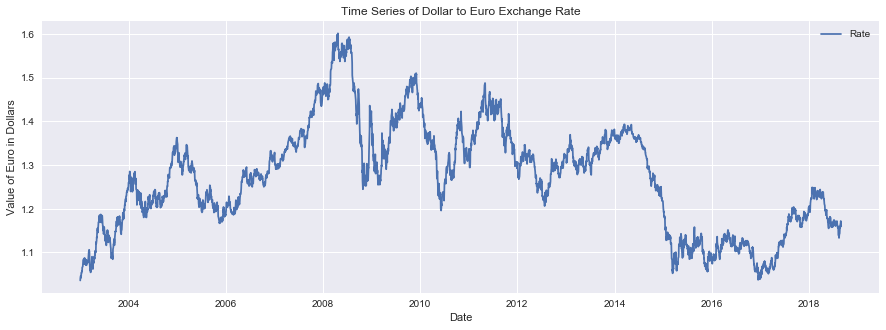

In [11]:
# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(time_series.Rate, label='Rate')
plt.title('Time Series of Dollar to Euro Exchange Rate')
plt.legend()
plt.show()

The value of the euro generally increased from 2003 through 2008.  There are then erratic rates that generally trend down through 2015.  There is a significant drop in relative value of the Euro from late 2009 to mid 2010, then again from 2014 to early 2015.

This plot makes it clear visually that our data is not stationary, in that it is not clustered around a single value.  By plotting the difference of each data point from the prior value, we should be able to see stationality.

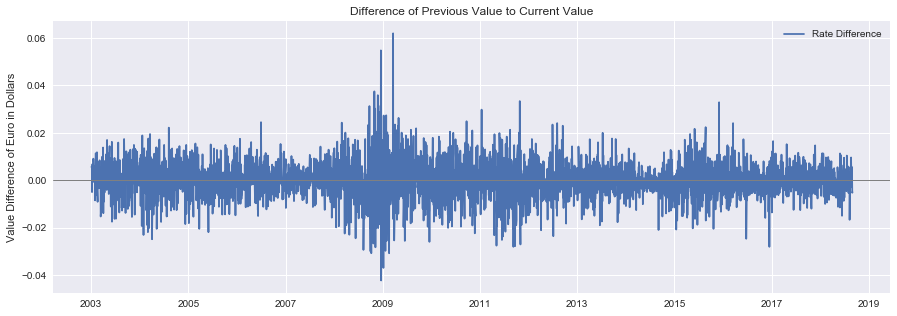

In [12]:
# difference of one record from previous
time_series['diff_1'] = time_series.Rate - time_series.Rate.shift()

plt.figure(figsize=(15, 5))
plt.plot(time_series.index, time_series.diff_1, label="Rate Difference")
plt.axhline(0, color='grey', linestyle='solid', linewidth=1)
plt.ylabel('Value Difference of Euro in Dollars')
plt.title('Difference of Previous Value to Current Value')
plt.legend()
plt.show()

That plot of difference shows the values custered around 0 - we have stationality in the data when taking a single difference.  This plot gives us insight into how our data values change from day to day.  We see greater volatility in the exchange rate in 2008 and 2009, with noticeable smaller extremes after 2009.  This reflects the economic instability of the time.  There is noticably more stability in the exchange rate in 2014 as less variation is seen from day to day.

We can mathematically test the stationality of the difference data using a Dickey Fuller test.

In [13]:
# Use statsmodel's augmented Diecky Fuller test
series = time_series.Rate
X = series.values
result = adfuller(X)
print('Exchange Rate Dickey Fuller Test')
print('Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

Exchange Rate Dickey Fuller Test
Statistic: -2.403107
p-value: 0.140861
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [14]:
# Dicky Fuller test on the difference data
series = time_series.diff_1.dropna()
X = series.values
result = adfuller(X)
print('Exchange Rate Difference Dickey Fuller Test')
print('Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

Exchange Rate Difference Dickey Fuller Test
Statistic: -62.348214
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


The Dickey Fuller test results show a much lower Statistic value for the differenced data, along with a much smaller p-value, indicating that the differenced data is stationary.

Now that we have some information about our time series, we'll separate out some training data and see what we can predict.

### Training and Test
Separate data into train and test at 70/30 split.

In [15]:
# define training set from original data
train_size = int(len(USEU_data) * 0.70)
train, test = USEU_data[0:train_size], USEU_data[train_size:len(USEU_data)]

# define training set from time series data
series_train, series_test = time_series[0:train_size], time_series[train_size:len(USEU_data)]

print('Observations: %d' % (len(USEU_data)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 3938
Training Observations: 2756
Testing Observations: 1182


In [16]:
test.head()

,Date,Rate
2756,2013-12-16,1.3757
2757,2013-12-17,1.3748
2758,2013-12-18,1.3766
2759,2013-12-19,1.3666
2760,2013-12-20,1.3673


In [17]:
test.tail()

,Date,Rate
3933,2018-08-27,1.1676
3934,2018-08-28,1.1720
3935,2018-08-29,1.1699
3936,2018-08-30,1.1646
3937,2018-08-31,1.1596


Our Training data cover almost eleven years, from January 2003 to December 2013.  The Test set is just under five years, from December 2013 to August 2018 (index 2756-3937).

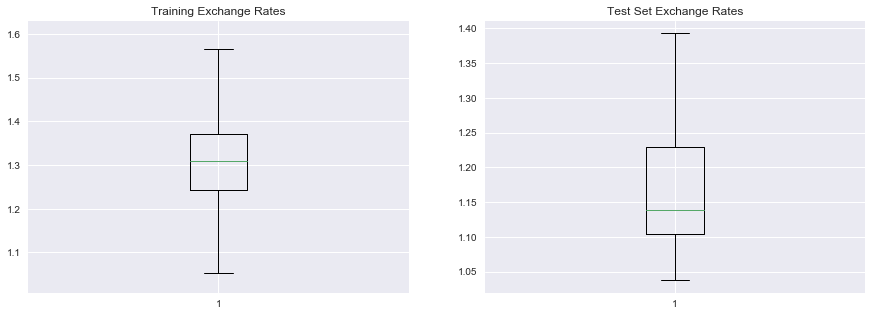

Training Mean Rate: $1.31
Test Mean Rate: $1.18


In [18]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.boxplot(train.Rate.dropna(how = 'any'))
plt.title('Training Exchange Rates')

plt.subplot(1, 2, 2)
plt.boxplot(test.Rate.dropna(how = 'any'))
plt.title('Test Set Exchange Rates')

plt.show()

print('Training Mean Rate: $%.2f' % (train.Rate.mean()))
print('Test Mean Rate: $%.2f' % (test.Rate.mean()))

These individual box plots of the training and test data show greater variation in the training set - with Euro values raging from just over 1.00 to over 1.60.  The test fits within that range, from 1.05 to 1.40.  <br>
This greater range of the training set includes several outliers on both the high and low ends, while the test set has no notable outliers.  The test set also shows a stronger value for the dollar, as the average Euro rate is notable lower than in the training set.

# Time Series Models
The primary algorithm for time series is the ARIMA model.  The model takes three parameters: <br>
AR for auto-regressive or how the data relates to it's prior values<br>
I for integrated or the level of differencing required to make the data stationary<br>
MA for moving average or how the data relates to prior errors

Since we saw stationarity in our data by taking the first difference, we will start with an integrated parameter of 1.

### AutoCorrelation Function (ACF) & Partial AutoCorrelation Function (PACF)
Comparing the exchange rate with a prior rates, testing for correlation.  Auto Correlation includes the impact of correlations between prior values, while the Partial Auto Correlation removes the impact of correlation to other prior values.  The values on the x-axis indicate the time-step shift.

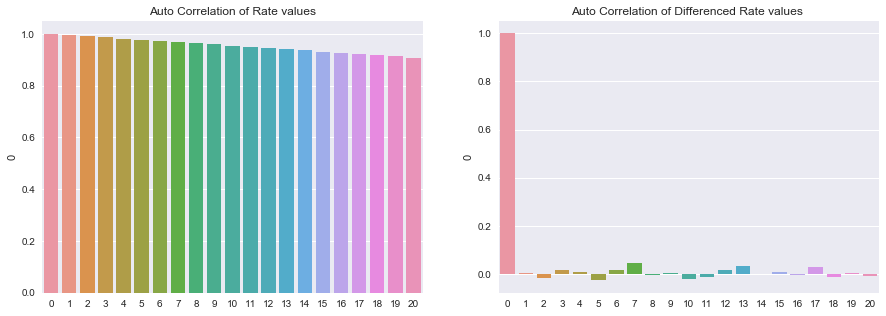

In [19]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
x_acf = pd.DataFrame(acf(series_train.Rate, nlags=20))
sns.barplot(x=x_acf.index, y=x_acf[0])
plt.title("Auto Correlation of Rate values")

plt.subplot(1, 2, 2)
x_acf_diff = pd.DataFrame(acf(series_train.diff_1[1:], nlags=20))
sns.barplot(x=x_acf_diff.index, y=x_acf_diff[0])
plt.title("Auto Correlation of Differenced Rate values ")
plt.show()

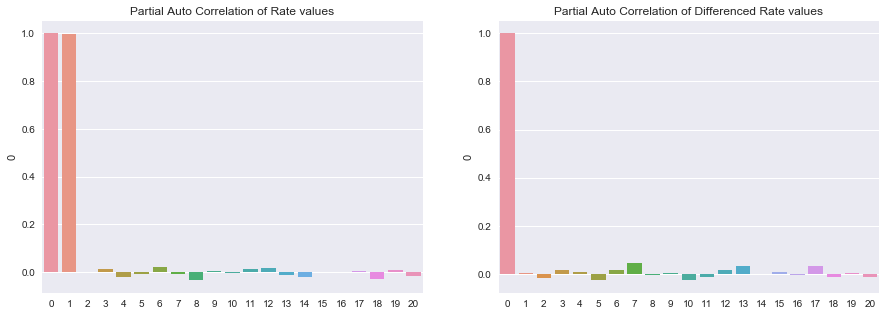

In [20]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
x_pacf = pd.DataFrame(pacf(series_train.Rate, nlags=20))
sns.barplot(x=x_pacf.index, y=x_pacf[0])
plt.title("Partial Auto Correlation of Rate values")

plt.subplot(1, 2, 2)
x_pacf_diff = pd.DataFrame(pacf(series_train.diff_1[1:], nlags=20))
sns.barplot(x=x_pacf_diff.index, y=x_pacf_diff[0])
plt.title("Partial Auto Correlation of Differenced Rate values")
plt.show()

The ACF of the original rates shows a gradual decline in correlations with increased time shifts.  The differenced data shows no auto correlation, although there is a slight elevation at 7 lags.<br>
The PACF of the original exchange rate values shows strong auto-correlation at 1.  The PACF of the exchange rate difference values shows no notable correlation, although the lag-7 again shows a slight elevation.  <br>
We'll run some additional tests to find the best parameters for our model, but 0 for the AR and MA elements will likely be well-suited.

## ARIMA model

### Using Auto Arima to for optimal test parameters
We will use the Akaike Information Criterion (AIC) to evaluate our models.  The AIC measures how well our data is explained by the model, relative to how complex it is.

In [21]:
train_step_model = auto_arima(train.Rate, start_p=1, start_q=1,
                           max_p=3, max_q=3, seasonal=False,
                           d=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(train_step_model.aic())

Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=-18441.104, BIC=-18429.261, Fit time=0.021 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-18439.164, BIC=-18421.401, Fit time=0.071 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-18439.166, BIC=-18421.402, Fit time=0.044 seconds
Total fit time: 0.409 seconds
-18441.103712277098


As anticipated, an ARIMA model with 0,1,0 configuration has the lowest AIC score on our initial test.  It is worth noting that the (1, 1, 0) and (0, 1, 1) also show AIC values very close to the (0, 1, 0) model.  This means each of these models are capturing the data with similar accuracy and parsimony.

In [22]:
train_step_model = auto_arima(train.Rate, p=7, start_q=2,
                           max_q=3, seasonal=False,
                           d=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=False)
print(train_step_model.aic())

Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 1, 2); AIC=-18437.215, BIC=-18395.767, Fit time=4.626 seconds
Fit ARIMA: order=(3, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(4, 1, 2); AIC=-18435.327, BIC=-18387.957, Fit time=4.260 seconds
Fit ARIMA: order=(4, 1, 3); AIC=-18433.663, BIC=-18380.372, Fit time=2.918 seconds
Fit ARIMA: order=(5, 1, 2); AIC=-18433.351, BIC=-18380.060, Fit time=3.286 seconds
Fit ARIMA: order=(5, 1, 3); AIC=-18431.381, BIC=-18372.169, Fit time=2.827 seconds
Total fit time: 18.612 seconds
-18437.21523242889


In [23]:
train_step_model = auto_arima(train.Rate, start_q=4, max_q=5,
                           p=7, seasonal=False,
                           d=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(train_step_model.aic())

Fit ARIMA: order=(2, 1, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=-18441.104, BIC=-18429.261, Fit time=0.014 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-18439.164, BIC=-18421.401, Fit time=0.044 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-18439.166, BIC=-18421.402, Fit time=0.049 seconds
Fit ARIMA: order=(1, 1, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.644 seconds
-18441.103712277098


### Using Auto Arima with seasonality to test for optimal parameters

In [24]:
train_step_model = auto_arima(train.Rate, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=365,
                           start_P=0, seasonal=True,
                           d=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(train_step_model.aic())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 365); AIC=-18441.104, BIC=-18429.261, Fit time=0.315 seconds


KeyboardInterrupt: 

In [25]:
train_step_model = auto_arima(train.Rate, seasonal=True,
                           m = 730, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(train_step_model.aic())

KeyboardInterrupt: 

In [ ]:
train_step_model = auto_arima(train.Rate, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(train_step_model.aic())

In [ ]:
train_step_model = auto_arima(train.Rate, start_p=1, start_q=2,
                           max_p=5, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(train_step_model.aic())

In [ ]:
train_step_model = auto_arima(train.Rate, p=2, start_q=1,
                           max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(train_step_model.aic())

### Training the model and Testing

In [26]:
# fit the model
model_010 = ARIMA(train.Rate, order=(0,1,0))
model_010_fit = model_010.fit()
print(model_010_fit.summary())
print('Residuals Description')
print(model_010_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                 D.Rate   No. Observations:                 2755
Model:                 ARIMA(0, 1, 0)   Log Likelihood                9222.552
Method:                           css   S.D. of innovations              0.009
Date:                Tue, 25 Sep 2018   AIC                         -18441.104
Time:                        21:01:48   BIC                         -18429.261
Sample:                             1   HQIC                        -18436.826
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.753      0.452      -0.000       0.000
Residuals Description
count    2.755000e+03
mean     2.919964e-10
std      8.511597e-03
min     -4.242207e-02
25%     -4.522069e-03

In [27]:
# fit the model
model_011 = ARIMA(train.Rate, order=(0,1,1))
model_011_fit = model_011.fit()
print(model_011_fit.summary())
print('Residuals Description')
print(model_011_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                 D.Rate   No. Observations:                 2755
Model:                 ARIMA(0, 1, 1)   Log Likelihood                9222.583
Method:                       css-mle   S.D. of innovations              0.009
Date:                Tue, 25 Sep 2018   AIC                         -18439.166
Time:                        21:01:52   BIC                         -18421.402
Sample:                             1   HQIC                        -18432.749
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0001      0.000      0.749      0.454      -0.000       0.000
ma.L1.D.Rate     0.0048      0.019      0.249      0.803      -0.033       0.043
                                    Roots   

In [28]:
# fit the model
model_122 = ARIMA(train.Rate, order=(1,2,2))
model_122_fit = model_122.fit()
print(model_122_fit.summary())
print('Residuals Description')
print(model_122_fit.resid.describe())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                D2.Rate   No. Observations:                 2754
Model:                 ARIMA(1, 2, 2)   Log Likelihood                9216.642
Method:                       css-mle   S.D. of innovations              0.009
Date:                Tue, 25 Sep 2018   AIC                         -18423.284
Time:                        21:01:58   BIC                         -18393.680
Sample:                             2   HQIC                        -18412.589
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.753e-07   2.04e-07     -0.858      0.391   -5.76e-07    2.25e-07
ar.L1.D2.Rate    -0.9850      0.013    -76.714      0.000      -1.010      -0.960
ma.L1.D2.Rate    -0.0093      0.010     

In [29]:
# fit the model
model_727 = ARIMA(train.Rate, order=(7,2,7))
model_727_fit = model_727.fit()
print(model_727_fit.summary())
print('Residuals Description')
print(model_727_fit.resid.describe())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                D2.Rate   No. Observations:                 2754
Model:                 ARIMA(7, 2, 7)   Log Likelihood                9218.013
Method:                       css-mle   S.D. of innovations              0.009
Date:                Tue, 25 Sep 2018   AIC                         -18404.027
Time:                        21:02:11   BIC                         -18309.294
Sample:                             2   HQIC                        -18369.803
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.563e-07   7.62e-07     -0.205      0.837   -1.65e-06    1.34e-06
ar.L1.D2.Rate    -1.3460      0.388     -3.471      0.001      -2.106      -0.586
ar.L2.D2.Rate    -1.4087      0.592     

In [30]:
# fit the model
model_710 = ARIMA(train.Rate, order=(7,1,0))
model_710_fit = model_710.fit()
print(model_710_fit.summary())
print('Residuals Description')
print(model_710_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                 D.Rate   No. Observations:                 2755
Model:                 ARIMA(7, 1, 0)   Log Likelihood                9227.503
Method:                       css-mle   S.D. of innovations              0.008
Date:                Tue, 25 Sep 2018   AIC                         -18437.006
Time:                        21:02:19   BIC                         -18383.715
Sample:                             1   HQIC                        -18417.754
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0001      0.000      0.719      0.472      -0.000       0.000
ar.L1.D.Rate     0.0048      0.019      0.251      0.802      -0.033       0.042
ar.L2.D.Rate    -0.0133      0.019     -0.69

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5,1,'Actual Difference with Predicted Difference with ARIMA 0,1,0 model')

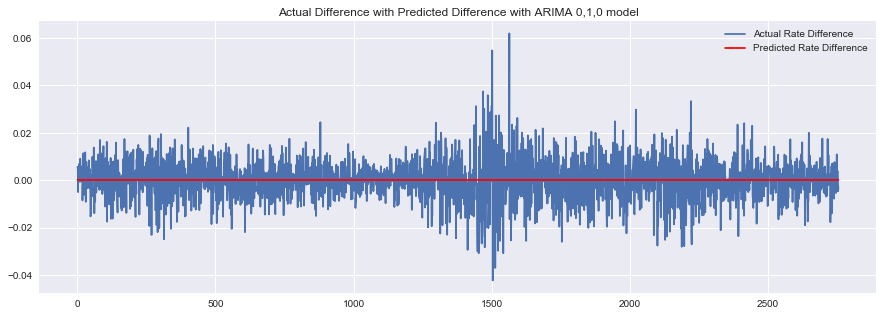

In [31]:
# https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
train['diff_1'] = train.Rate - train.Rate.shift()
model = ARIMA(train.Rate, order=(0, 1, 0))  
results_ARIMA = model.fit(disp=-1)  

plt.figure(figsize=(15, 5))
plt.plot(train.index, train.diff_1, label="Actual Rate Difference")
plt.plot(results_ARIMA.fittedvalues, color='red', label="Predicted Rate Difference")
plt.legend()
plt.title('Actual Difference with Predicted Difference with ARIMA 0,1,0 model')

Text(0.5,1,'Actual Difference with Predicted Difference with ARIMA 7,1,0 model')

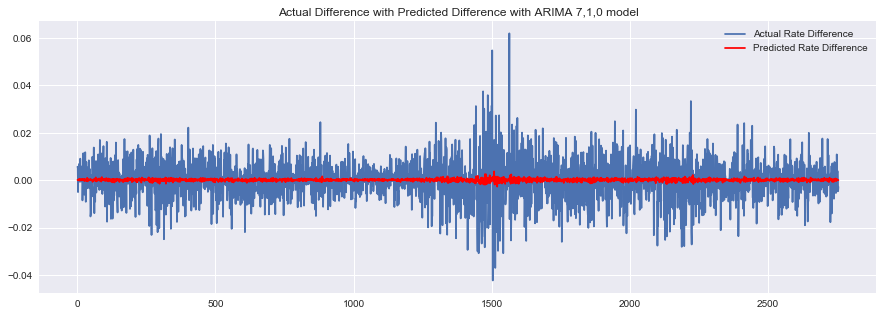

In [32]:
# https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
model = ARIMA(train.Rate, order=(7, 1, 0))  
results_ARIMA = model.fit(disp=-1)  

plt.figure(figsize=(15, 5))
plt.plot(train.index, train.diff_1, label="Actual Rate Difference")
plt.plot(results_ARIMA.fittedvalues, color='red', label="Predicted Rate Difference")
plt.legend()
plt.title('Actual Difference with Predicted Difference with ARIMA 7,1,0 model')

Text(0.5,1,'Actual Difference with Predicted Difference with ARIMA 1,2,2 model')

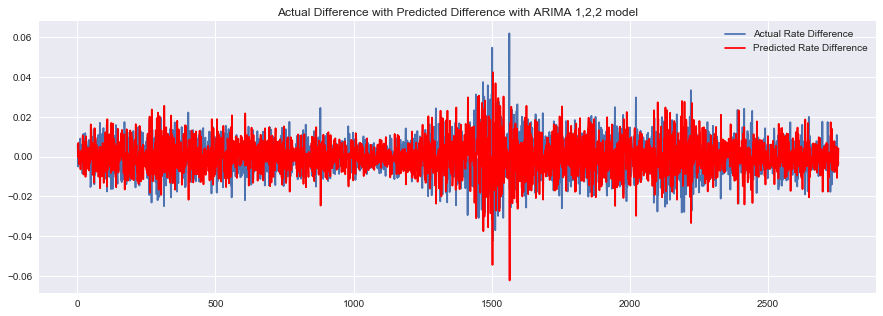

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(train.index, train.diff_1, label="Actual Rate Difference")
plt.plot(model_122_fit.fittedvalues, color='red', label="Predicted Rate Difference")
plt.legend()
plt.title('Actual Difference with Predicted Difference with ARIMA 1,2,2 model')

Text(0.5,1,'Actual Difference with Predicted Difference with ARIMA 0,1,1 model')

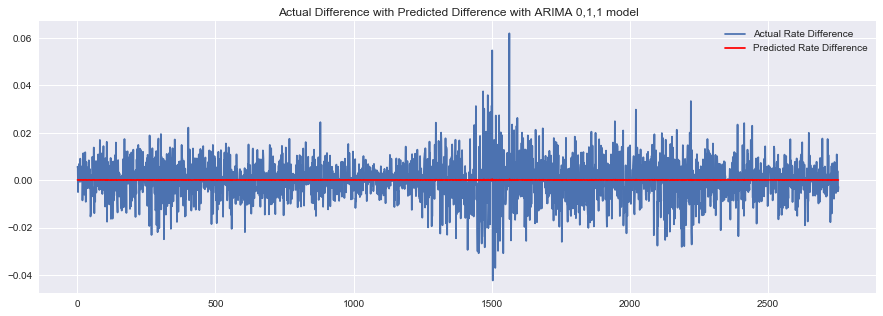

In [34]:

plt.figure(figsize=(15, 5))
plt.plot(train.index, train.diff_1, label="Actual Rate Difference")
plt.plot(model_011_fit.fittedvalues, color='red', label="Predicted Rate Difference")
plt.legend()
plt.title('Actual Difference with Predicted Difference with ARIMA 0,1,1 model')

# Prediction

### Out of Sample Forecasting
Predicting values for the test range and comparing to actual values

In [35]:
# prediction (test) index range
start_index = 2756
end_index = 3937

Predicting values with the ARIMA (7, 1, 0) model.

In [36]:
# add predictions to data in new dataframe
future_forecast = model_710_fit.predict(start=start_index, end=end_index, dynamic=True)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['predict_710'])
test_predict = pd.concat([test, future_forecast], axis=1)
test_predict.head()

,Date,Rate,predict_710
2756,2013-12-16,1.3757,0.000689
2757,2013-12-17,1.3748,0.000191
2758,2013-12-18,1.3766,0.000161
2759,2013-12-19,1.3666,0.000446
2760,2013-12-20,1.3673,0.000271


In [37]:
# calculate first predicted value
test_predict.loc[2756, ('Rate_710')] = train.loc[2755, ('Rate')] + test_predict.loc[2756, ('predict_710')]

#calculate remaining values
for i in range(start_index+1, end_index):
    old_rate = test_predict.loc[(i-1), ('Rate_710')]
    current_pred = test_predict.loc[i, ('predict_710')]
    new_rate = old_rate + current_pred
    test_predict.loc[i, ('Rate_710')] = new_rate
test_predict.head()

,Date,Rate,predict_710,Rate_710
2756,2013-12-16,1.3757,0.000689,1.373089
2757,2013-12-17,1.3748,0.000191,1.373280
2758,2013-12-18,1.3766,0.000161,1.373441
2759,2013-12-19,1.3666,0.000446,1.373887
2760,2013-12-20,1.3673,0.000271,1.374157


In [38]:
test_predict.shape

(1182, 4)

In [39]:
predict_series = test_predict.copy()
predict_series.index = pd.to_datetime(predict_series['Date'])
predict_series.head()

,Date,Rate,predict_710,Rate_710
Date,,,,
2013-12-16,2013-12-16,1.3757,0.000689,1.373089
2013-12-17,2013-12-17,1.3748,0.000191,1.373280
2013-12-18,2013-12-18,1.3766,0.000161,1.373441
2013-12-19,2013-12-19,1.3666,0.000446,1.373887
2013-12-20,2013-12-20,1.3673,0.000271,1.374157


In [40]:
predict_series.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,1182.0,1.175052,0.096995,1.037500,1.103800,1.139100,1.229775,1.392700
predict_710,1182.0,0.000123,0.000022,-0.000153,0.000123,0.000123,0.000123,0.000689
Rate_710,1181.0,1.445673,0.041833,1.373089,1.409490,1.445673,1.481856,1.518039


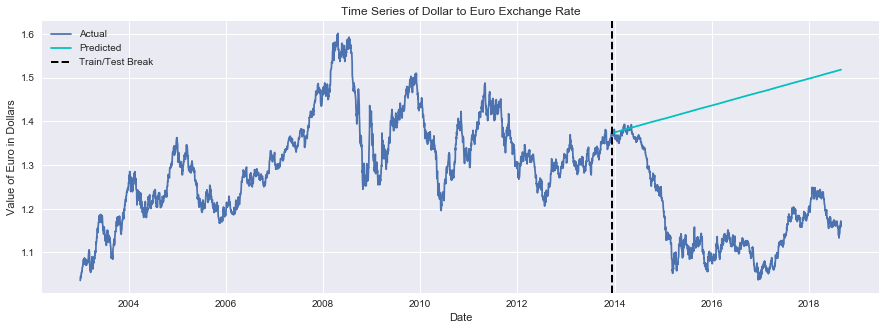

In [41]:
# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(time_series.Rate, label='Actual')
plt.plot(predict_series.Rate_710, label='Predicted', color='c')
plt.axvline(series_test.index[0], color='k', linestyle='dashed', linewidth=2, label="Train/Test Break")
plt.grid(True)
plt.title('Time Series of Dollar to Euro Exchange Rate')
plt.legend()
plt.show()

Predicting values with ARIMA (0, 1, 0) model.

In [42]:
# add predictions to data in new dataframe
future_forecast = model_010_fit.predict(start=start_index, end=end_index, dynamic=True)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['predict_010'])
test_predict = pd.concat([test, future_forecast], axis=1)

# calculate first predicted value
test_predict.loc[2756, ('Rate_010')] = train.loc[2755, ('Rate')] + test_predict.loc[2756, ('predict_010')]

#calculate remaining values
for i in range(start_index+1, end_index):
    old_rate = test_predict.loc[(i-1), ('Rate_010')]
    current_pred = test_predict.loc[i, ('predict_010')]
    new_rate = old_rate + current_pred
    test_predict.loc[i, ('Rate_010')] = new_rate

# creating time series of test and prediction
predict_series = test_predict.copy()
predict_series.index = pd.to_datetime(predict_series['Date'])

# describe time series data
predict_series.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,1182.0,1.175052,0.096995,1.037500,1.103800,1.139100,1.229775,1.392700
predict_010,1182.0,0.000122,0.000000,0.000122,0.000122,0.000122,0.000122,0.000122
Rate_010,1181.0,1.444543,0.041634,1.372522,1.408532,1.444543,1.480553,1.516563


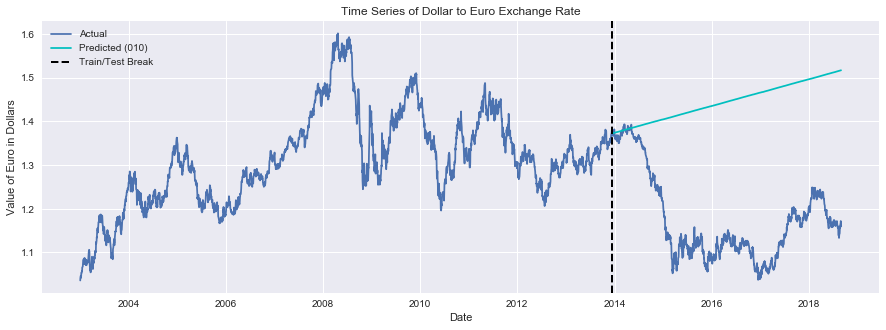

In [43]:
# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(time_series.Rate, label='Actual')
plt.plot(predict_series.Rate_010, label='Predicted (010)', color='c')
plt.axvline(series_test.index[0], color='k', linestyle='dashed', linewidth=2, label="Train/Test Break")
plt.grid(True)
plt.title('Time Series of Dollar to Euro Exchange Rate')
plt.legend()
plt.show()

In [44]:
# calculate residuals
predict_series.resid_010 = 0
predict_series.resid_010 = predict_series.Rate - predict_series.Rate_010

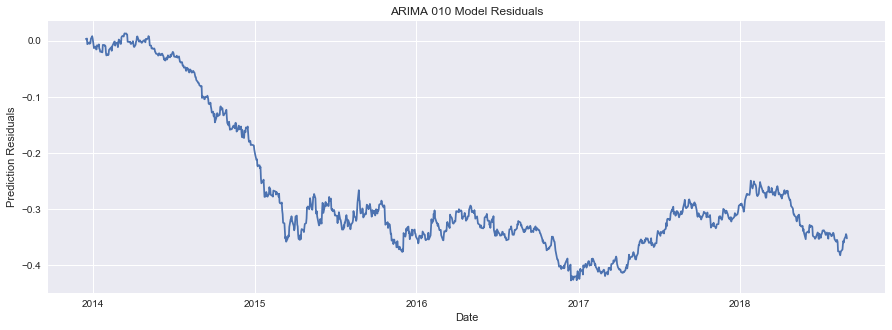

In [45]:
# plot residuals by date
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Prediction Residuals')
plt.plot(predict_series.resid_010)
plt.title('ARIMA 010 Model Residuals')
plt.show()

              Rate  predict_710     Rate_710    resid_710
count  1182.000000  1182.000000  1181.000000  1181.000000
mean      1.175052     0.000123     1.445673    -0.270608
std       0.096995     0.000022     0.041833     0.122327
min       1.037500    -0.000153     1.373089    -0.428043
25%       1.103800     0.000123     1.409490    -0.345524
50%       1.139100     0.000123     1.445673    -0.314352
75%       1.229775     0.000123     1.481856    -0.265514
max       1.392700     0.000689     1.518039     0.012157


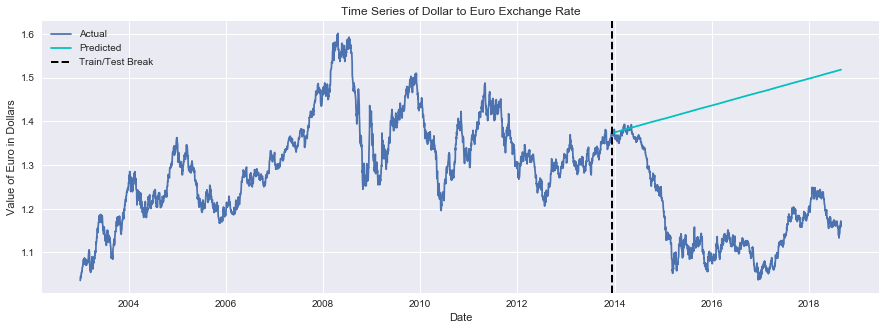

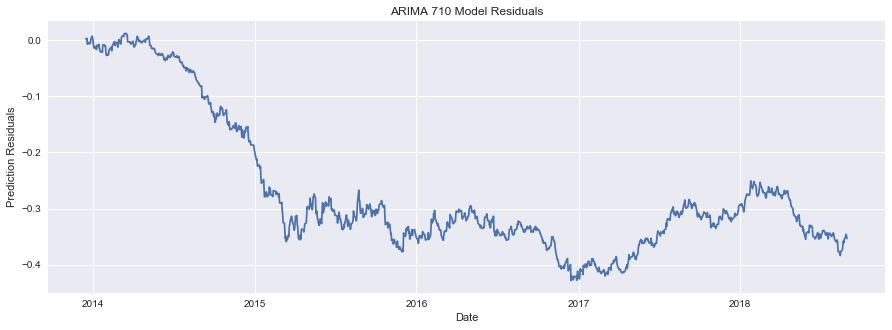

In [46]:
# make predictions and compare to test

# add predictions to data in new dataframe
future_forecast = model_710_fit.predict(start=start_index, end=end_index, dynamic=True)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['predict_710'])
test_predict = pd.concat([test, future_forecast], axis=1)

# calculate first predicted value
test_predict.loc[2756, ('Rate_710')] = train.loc[2755, ('Rate')] + test_predict.loc[2756, ('predict_710')]

#calculate remaining values
for i in range(start_index+1, end_index):
    old_rate = test_predict.loc[(i-1), ('Rate_710')]
    current_pred = test_predict.loc[i, ('predict_710')]
    new_rate = old_rate + current_pred
    test_predict.loc[i, ('Rate_710')] = new_rate
    
# calculate residuals
test_predict['resid_710'] = 0
test_predict.resid_710 = test_predict.Rate - test_predict.Rate_710

# create time series of predictions
predict_series = test_predict.copy()
predict_series.index = pd.to_datetime(predict_series['Date'])

# describe time series data
print(predict_series.describe())

# plot time series
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Value of Euro in Dollars')
plt.plot(time_series.Rate, label='Actual')
plt.plot(predict_series.Rate_710, label='Predicted', color='c')
plt.axvline(series_test.index[0], color='k', linestyle='dashed', linewidth=2, label="Train/Test Break")
plt.grid(True)
plt.title('Time Series of Dollar to Euro Exchange Rate')
plt.legend()
plt.show()

# plot residuals by date
plt.figure(figsize=(15, 5))
plt.xlabel('Date')
plt.ylabel('Prediction Residuals')
plt.plot(predict_series.resid_710)
plt.title('ARIMA 710 Model Residuals')
plt.show()

In [47]:
# define methods to make predictions and compare to test data

def predict_test(p,d,q):
    # define and fit model
    model = ARIMA(train.Rate, order=(p, d, q))  
    results_ARIMA = model.fit()  
    
    # add predictions to data in new dataframe
    future_forecast = results_ARIMA.predict(start=start_index, end=end_index, dynamic=True)
    future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['predict'])
    test_predict = pd.concat([test, future_forecast], axis=1)

    # calculate first predicted value
    test_predict.loc[start_index, ('Predicted_Rate')] = train.loc[(start_index-1), ('Rate')] + test_predict.loc[start_index, ('predict')]

    #calculate remaining values
    for i in range(start_index+1, end_index):
        old_rate = test_predict.loc[(i-1), ('Predicted_Rate')]
        current_pred = test_predict.loc[i, ('predict')]
        new_rate = old_rate + current_pred
        test_predict.loc[i, ('Predicted_Rate')] = new_rate
    
    # calculate residuals
    test_predict['Residual'] = 0
    test_predict.Residual = test_predict.Rate - test_predict.Predicted_Rate

    # create time series of predictions
    predict_series = test_predict.copy()
    predict_series.index = pd.to_datetime(predict_series['Date'])

    # describe time series data
    print(predict_series.describe())

    # plot time series
    plt.figure(figsize=(15, 5))
    plt.xlabel('Date')
    plt.ylabel('Value of Euro in Dollars')
    plt.plot(time_series.Rate, label='Actual')
    plt.plot(predict_series.Predicted_Rate, label='Predicted', color='c')
    plt.axvline(series_test.index[0], color='k', linestyle='dashed', linewidth=2, label="Train/Test Break")
    plt.title('Predicted Test Range Rates from ARIMA ' + str(p) + str(d) + str(q))
    plt.legend()
    plt.show()

    # plot residuals by date
    plt.figure(figsize=(15, 5))
    plt.xlabel('Date')
    plt.ylabel('Prediction Residuals')
    plt.plot(predict_series.Residual)
    plt.title('Model Residuals from ARIMA ' + str(p) + str(d) + str(q))
    plt.show()

              Rate      predict  Predicted_Rate     Residual
count  1182.000000  1182.000000     1181.000000  1181.000000
mean      1.175052     0.000122        1.444543    -0.269477
std       0.096995     0.000000        0.041634     0.122185
min       1.037500     0.000122        1.372522    -0.426818
25%       1.103800     0.000122        1.408532    -0.344302
50%       1.139100     0.000122        1.444543    -0.313205
75%       1.229775     0.000122        1.480553    -0.264569
max       1.392700     0.000122        1.516563     0.012976


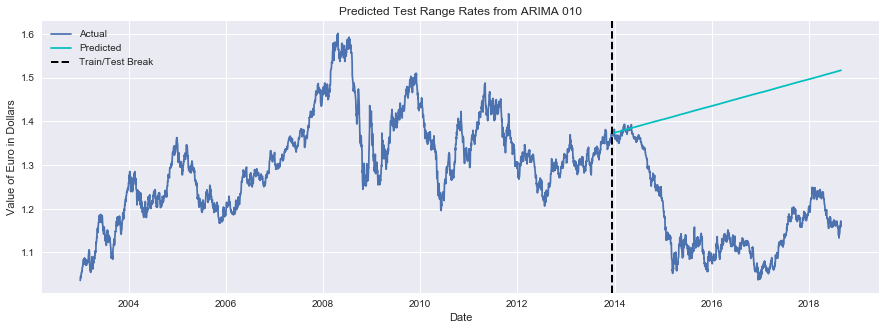

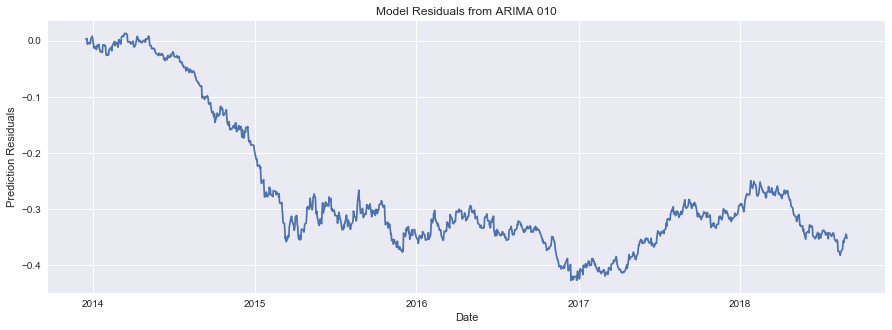

In [48]:
predict_test(0,1,0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


              Rate       predict  Predicted_Rate     Residual
count  1182.000000  1.182000e+03     1181.000000  1181.000000
mean      1.175052  2.094078e-06        1.374979    -0.199914
std       0.096995  1.345884e-04        0.000079     0.097007
min       1.037500 -6.101501e-04        1.374779    -0.337450
25%       1.103800 -2.544220e-07        1.374923    -0.271158
50%       1.139100 -1.753299e-07        1.374972    -0.235982
75%       1.229775 -9.503000e-08        1.375019    -0.145099
max       1.392700  2.989564e-03        1.375390     0.017754


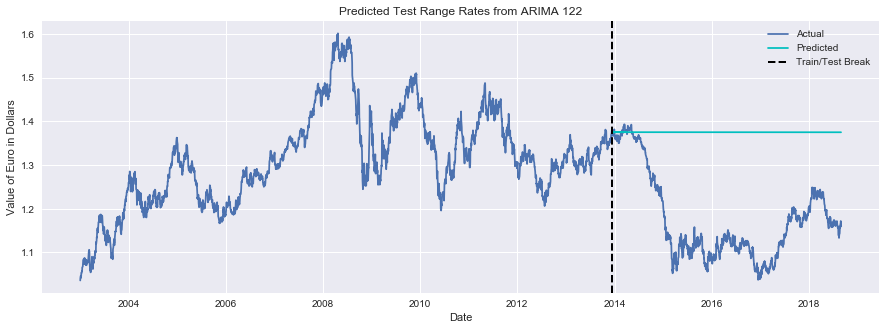

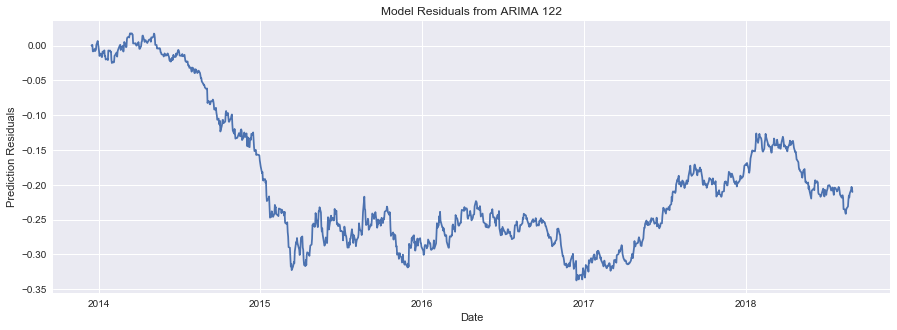

In [49]:
predict_test(1,2,2)

### test predictions with histogram of residuals

In [50]:
# define methods to make predictions and compare to test data

def predict_test(p,d,q):
    # define and fit model
    model = ARIMA(train.Rate, order=(p, d, q))  
    results_ARIMA = model.fit()  
    
    # add predictions to data in new dataframe
    future_forecast = results_ARIMA.predict(start=start_index, end=end_index, dynamic=True)
    future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['predict'])
    test_predict = pd.concat([test, future_forecast], axis=1)

    # calculate first predicted value
    test_predict.loc[start_index, ('Predicted_Rate')] = train.loc[(start_index-1), ('Rate')] + test_predict.loc[start_index, ('predict')]

    #calculate remaining values
    for i in range(start_index+1, end_index):
        old_rate = test_predict.loc[(i-1), ('Predicted_Rate')]
        current_pred = test_predict.loc[i, ('predict')]
        new_rate = old_rate + current_pred
        test_predict.loc[i, ('Predicted_Rate')] = new_rate
    
    # calculate residuals
    test_predict['Residual'] = 0
    test_predict.Residual = test_predict.Rate - test_predict.Predicted_Rate

    # create time series of predictions
    predict_series = test_predict.copy()
    predict_series.index = pd.to_datetime(predict_series['Date'])

    # describe time series data
    print(predict_series.describe())

    # plot time series
    plt.figure(figsize=(15, 5))
    plt.xlabel('Date')
    plt.ylabel('Value of Euro in Dollars')
    plt.plot(time_series.Rate, label='Actual')
    plt.plot(predict_series.Predicted_Rate, label='Predicted', color='c')
    plt.axvline(series_test.index[0], color='k', linestyle='dashed', linewidth=2, label="Train/Test Break")
    plt.title('Predicted Test Range Rates from ARIMA ' + str(p) + str(d) + str(q))
    plt.legend()
    plt.show()

    # plot residuals by date
    plt.figure(figsize=(15, 5))
    plt.xlabel('Date')
    plt.ylabel('Prediction Residuals')
    plt.plot(predict_series.Residual)
    plt.title('Model Residuals from ARIMA ' + str(p) + str(d) + str(q))
    plt.show()
    
    # residual plot
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.hist(predict_series.Residual)
    plt.title('Residual counts')
    plt.xlabel('Residual')
    plt.ylabel('Count')
    
    plt.subplot(1, 3, 2)
    plt.scatter(predicted, residual)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.axhline(y=0)
    plt.title('Residual vs. Predicted')
    
    plt.subplot(1, 3, 3)
    plt.scatter(predicted, Y)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.axhline(y=0)
    plt.title('Actual vs. Predicted')
    
    plt.show()

In [ ]:
# define methods to make predictions and compare to test data

def predict_test(p,d,q):
    # define and fit model
    model = ARIMA(train.Rate, order=(p, d, q))  
    results_ARIMA = model.fit()  
    
    # add predictions to data in new dataframe
    future_forecast = results_ARIMA.predict(start=start_index, end=end_index, dynamic=True)
    future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['predict'])
    test_predict = pd.concat([test, future_forecast], axis=1)

    # calculate first predicted value
    test_predict.loc[start_index, ('Predicted_Rate')] = train.loc[(start_index-1), ('Rate')] + test_predict.loc[start_index, ('predict')]

    #calculate remaining values
    for i in range(start_index+1, end_index):
        old_rate = test_predict.loc[(i-1), ('Predicted_Rate')]
        current_pred = test_predict.loc[i, ('predict')]
        new_rate = old_rate + current_pred
        test_predict.loc[i, ('Predicted_Rate')] = new_rate
    
    # calculate residuals
    test_predict['Residual'] = 0
    test_predict.Residual = test_predict.Rate - test_predict.Predicted_Rate

    # create time series of predictions
    predict_series = test_predict.copy()
    predict_series.index = pd.to_datetime(predict_series['Date'])

    # describe time series data
    print(predict_series.describe())

    # plot time series
    plt.figure(figsize=(15, 5))
    plt.xlabel('Date')
    plt.ylabel('Value of Euro in Dollars')
    plt.plot(time_series.Rate, label='Actual')
    plt.plot(predict_series.Predicted_Rate, label='Predicted', color='c')
    plt.axvline(series_test.index[0], color='k', linestyle='dashed', linewidth=2, label="Train/Test Break")
    plt.title('Predicted Test Range Rates from ARIMA ' + str(p) + str(d) + str(q))
    plt.legend()
    plt.show()

    # plot residuals by date
    plt.figure(figsize=(15, 5))
    plt.xlabel('Date')
    plt.ylabel('Prediction Residuals')
    plt.plot(predict_series.Residual)
    plt.title('Model Residuals from ARIMA ' + str(p) + str(d) + str(q))
    plt.show()
    
    # residual plot
    plt.hist(predict_series.Residual)
    plt.title('Residual counts')
    plt.xlabel('Residual')
    plt.ylabel('Count')
    
    plt.show()

              Rate      predict  Predicted_Rate     Residual
count  1182.000000  1182.000000     1181.000000  1181.000000
mean      1.175052     0.000122        1.444543    -0.269477
std       0.096995     0.000000        0.041634     0.122185
min       1.037500     0.000122        1.372522    -0.426818
25%       1.103800     0.000122        1.408532    -0.344302
50%       1.139100     0.000122        1.444543    -0.313205
75%       1.229775     0.000122        1.480553    -0.264569
max       1.392700     0.000122        1.516563     0.012976


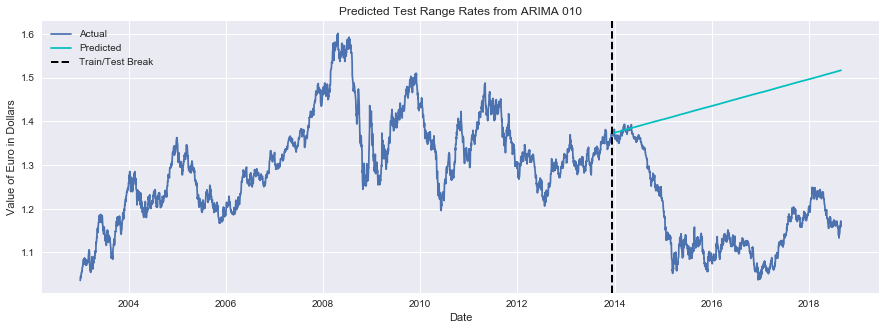

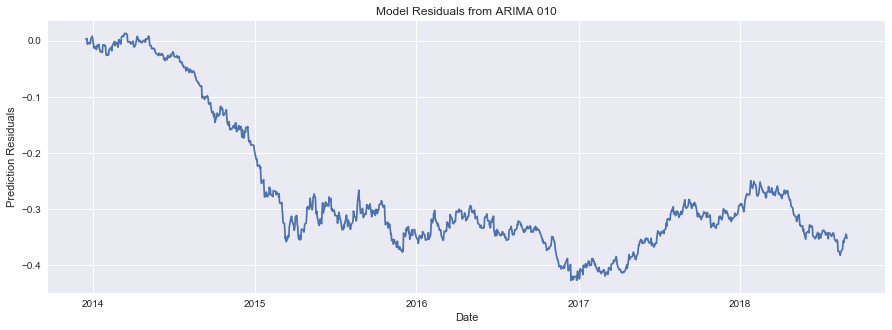

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: max must be larger than min in range parameter.

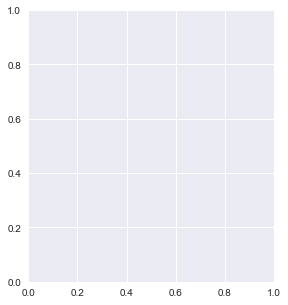

In [51]:
predict_test(0,1,0)

### test seasonal models

In [52]:
# define methods to make predictions and compare to test data

def seasonal_predict_test(p,d,q,P,D,Q,m):
    # define and fit model
    model = sm.tsa.statespace.SARIMAX(train.Rate, order=(p,d,q), seasonal_order=(P,D,Q,m))
    results_ARIMA = model.fit()  
    
    # add predictions to data in new dataframe
    future_forecast = results_ARIMA.predict(start=start_index, end=end_index, dynamic=True)
    future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['predict'])
    test_predict = pd.concat([test, future_forecast], axis=1)

    # calculate first predicted value
    test_predict.loc[start_index, ('Predicted_Rate')] = train.loc[(start_index-1), ('Rate')] + test_predict.loc[start_index, ('predict')]

    #calculate remaining values
    for i in range(start_index+1, end_index):
        old_rate = test_predict.loc[(i-1), ('Predicted_Rate')]
        current_pred = test_predict.loc[i, ('predict')]
        new_rate = old_rate + current_pred
        test_predict.loc[i, ('Predicted_Rate')] = new_rate
    
    # calculate residuals
    test_predict['Residual'] = 0
    test_predict.Residual = test_predict.Rate - test_predict.Predicted_Rate

    # create time series of predictions
    predict_series = test_predict.copy()
    predict_series.index = pd.to_datetime(predict_series['Date'])

    # describe time series data
    print(predict_series.describe())

    # plot time series
    plt.figure(figsize=(15, 5))
    plt.xlabel('Date')
    plt.ylabel('Value of Euro in Dollars')
    plt.plot(time_series.Rate, label='Actual')
    plt.plot(predict_series.Predicted_Rate, label='Predicted', color='c')
    plt.axvline(series_test.index[0], color='k', linestyle='dashed', linewidth=2, label="Train/Test Break")
    plt.title('Predicted Test Range Rates from ARIMA ' + str(p) + str(d) + str(q))
    plt.legend()
    plt.show()

    # plot residuals by date
    plt.figure(figsize=(15, 5))
    plt.xlabel('Date')
    plt.ylabel('Prediction Residuals')
    plt.plot(predict_series.Residual)
    plt.title('Model Residuals from ARIMA ' + str(p) + str(d) + str(q))
    plt.show()

              Rate      predict  Predicted_Rate     Residual
count  1182.000000  1182.000000     1181.000000  1181.000000
mean      1.175052     1.531702      873.116659  -871.941594
std       0.096995     0.100778      522.712736   522.755999
min       1.037500     1.311800        2.736400 -1808.972179
25%       1.103800     1.441025      416.715998 -1320.978687
50%       1.139100     1.531200      856.947493  -855.820093
75%       1.229775     1.621300     1322.115087  -415.581398
max       1.392700     1.736600     1810.136779    -1.360700


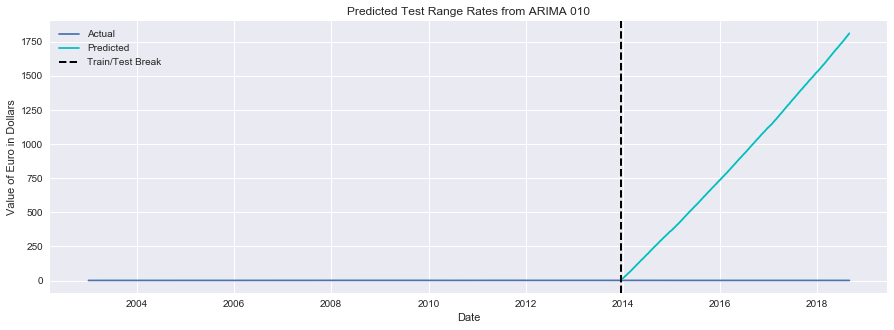

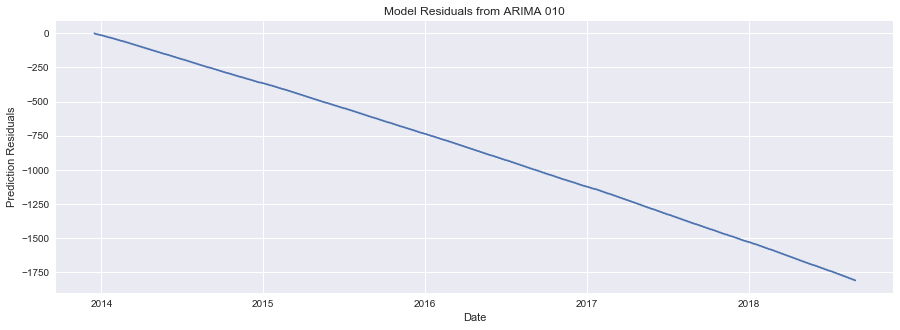

In [53]:
seasonal_predict_test(0,1,0,0,1,0,365)

### test fitted models

In [54]:
# define methods to make predictions and compare to test data

def model_test(model): 
    
    # add predictions to data in new dataframe
    future_forecast = model.predict(start=start_index, end=end_index, dynamic=True)
    future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['predict'])
    test_predict = pd.concat([test, future_forecast], axis=1)

    # calculate first predicted value
    test_predict.loc[start_index, ('Predicted_Rate')] = train.loc[(start_index-1), ('Rate')] + test_predict.loc[start_index, ('predict')]

    #calculate remaining values
    for i in range(start_index+1, end_index):
        old_rate = test_predict.loc[(i-1), ('Predicted_Rate')]
        current_pred = test_predict.loc[i, ('predict')]
        new_rate = old_rate + current_pred
        test_predict.loc[i, ('Predicted_Rate')] = new_rate
    
    # calculate residuals
    test_predict['Residual'] = 0
    test_predict.Residual = test_predict.Rate - test_predict.Predicted_Rate

    # create time series of predictions
    predict_series = test_predict.copy()
    predict_series.index = pd.to_datetime(predict_series['Date'])

    # describe time series data
    print(predict_series.describe())

    # plot time series
    plt.figure(figsize=(15, 5))
    plt.xlabel('Date')
    plt.ylabel('Value of Euro in Dollars')
    plt.plot(time_series.Rate, label='Actual')
    plt.plot(predict_series.Predicted_Rate, label='Predicted', color='c')
    plt.axvline(series_test.index[0], color='k', linestyle='dashed', linewidth=2, label="Train/Test Break")
    plt.title('Predicted Test Range Rates from ARIMA ' + str(model))
    plt.legend()
    plt.show()

    # plot residuals by date
    plt.figure(figsize=(15, 5))
    plt.xlabel('Date')
    plt.ylabel('Prediction Residuals')
    plt.plot(predict_series.Residual)
    plt.title('Model Residuals from ARIMA ' + str(model))
    plt.show()

              Rate       predict  Predicted_Rate     Residual
count  1182.000000  1.182000e+03     1181.000000  1181.000000
mean      1.175052  2.094078e-06        1.374979    -0.199914
std       0.096995  1.345884e-04        0.000079     0.097007
min       1.037500 -6.101501e-04        1.374779    -0.337450
25%       1.103800 -2.544220e-07        1.374923    -0.271158
50%       1.139100 -1.753299e-07        1.374972    -0.235982
75%       1.229775 -9.503000e-08        1.375019    -0.145099
max       1.392700  2.989564e-03        1.375390     0.017754


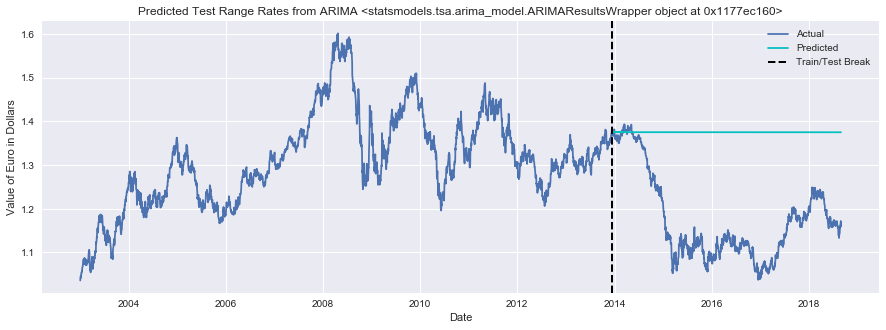

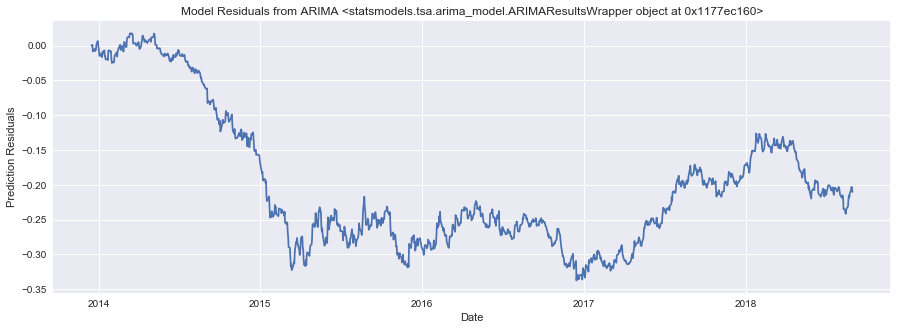

In [55]:
model_test(model_122_fit)

              Rate       predict  Predicted_Rate     Residual
count  1182.000000  1.182000e+03     1181.000000  1181.000000
mean      1.175052  1.220568e-04        1.444529    -0.269463
std       0.096995  4.067680e-07        0.041634     0.122185
min       1.037500  1.080839e-04        1.372508    -0.426804
25%       1.103800  1.220687e-04        1.408518    -0.344288
50%       1.139100  1.220687e-04        1.444529    -0.313191
75%       1.229775  1.220687e-04        1.480539    -0.264555
max       1.392700  1.220687e-04        1.516549     0.012990


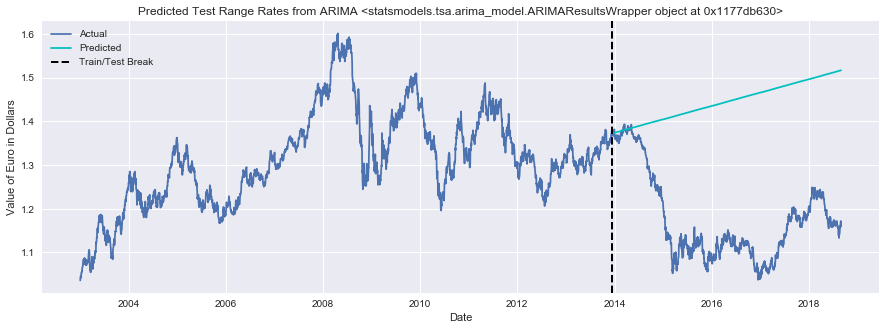

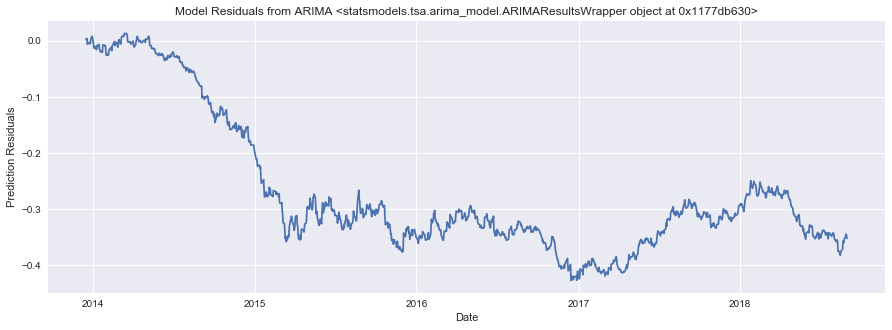

In [56]:
model_test(model_011_fit)

In [57]:
# fit the model
modelS_010 = sm.tsa.statespace.SARIMAX(train.Rate, trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))

modelS_010_fit = modelS_010.fit()
print(modelS_010_fit.summary())
print('Residuals Description')
print(modelS_010_fit.resid.describe())

                                 Statespace Model Results                                 
Dep. Variable:                               Rate   No. Observations:                 2756
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                9148.431
Date:                            Tue, 25 Sep 2018   AIC                         -18290.862
Time:                                    21:34:54   BIC                         -18273.111
Sample:                                         0   HQIC                        -18284.448
                                           - 2756                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0159      0.017      0.960      0.337      -0.017       0.048
ma.S.L12      -0.9972      0.012   

              Rate      predict  Predicted_Rate     Residual
count  1182.000000  1182.000000     1181.000000  1181.000000
mean      1.175052     1.441415      839.693268  -838.518203
std       0.096995     0.039713      491.660799   491.705294
min       1.037500     1.372185        2.744585 -1702.450188
25%       1.103800     1.407184      412.775744 -1262.076289
50%       1.139100     1.441404      832.933317  -831.805917
75%       1.229775     1.475829     1263.212689  -411.641144
max       1.392700     1.510436     1703.614788    -1.368885


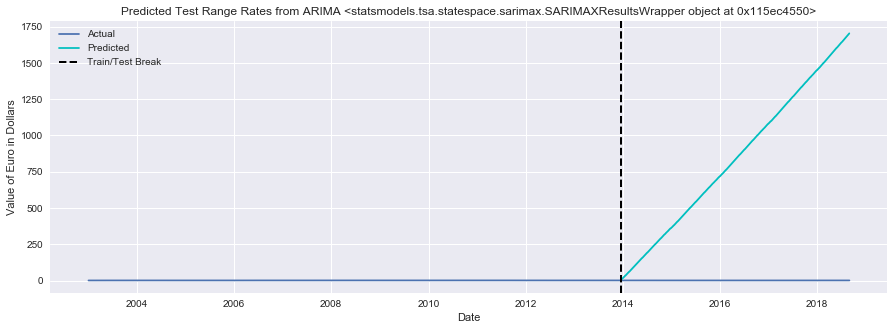

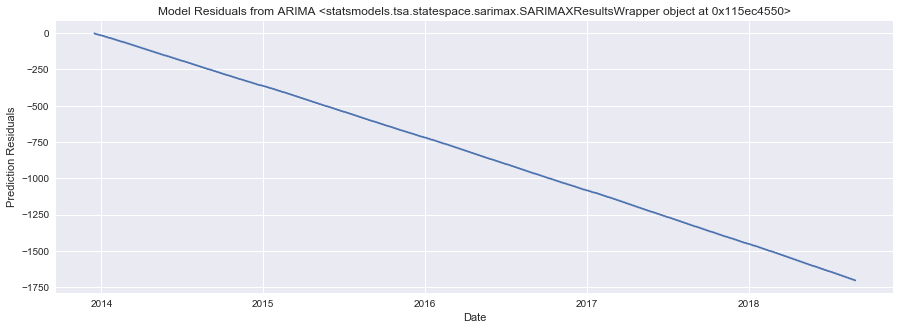

In [58]:
model_test(modelS_010_fit)

## Rolling Forecast
Predicting exchange rate one day at a time, adding actual value for each day before predicting the next.

In [ ]:
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [ ]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,2,2))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

In [ ]:
plt.figure(figsize=(15, 5))
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

## Dynamic Forecast

In [59]:
#pred_dynamic = model_011_fit.get_prediction(start=pd.to_datetime('2013-12-16'), dynamic=True, full_results=True)

pred_dynamic = model_122_fit.predict(start=start_index, dynamic=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = y[start_date:].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(start_date), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Rate')

plt.legend()
plt.show()

AttributeError: 'Series' object has no attribute 'conf_int'

In [ ]:
# https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/

In [60]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.Rate, order=(1, 2, 2),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2013-11-1", end="2013-12-31", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

ValueError: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.